In [4]:
import os
os.system('cls' if os.name == 'nt' else 'clear')

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import importlib  # Pour recharger le module
pd.set_option('future.no_silent_downcasting', True)
from decimal import Decimal, getcontext
from config import config as cf

# Foyer

In [ ]:
import main
importlib.reload(main)
df, SEMAINES = main.export_df_for_graph()

hiver
Modélisation stochastique du comportement d'un système PV-batterie
printemps
Modélisation stochastique du comportement d'un système PV-batterie
ete
Modélisation stochastique du comportement d'un système PV-batterie
automne
Modélisation stochastique du comportement d'un système PV-batterie
Taille finale : 672 lignes

Time: 152.43
hiver
Modélisation stochastique du comportement d'un système PV-batterie
printemps
Modélisation stochastique du comportement d'un système PV-batterie
ete
Modélisation stochastique du comportement d'un système PV-batterie
automne
Modélisation stochastique du comportement d'un système PV-batterie
Taille finale : 672 lignes

Time: 0.23


In [17]:
col_ajoutee = ("SOC_charge", "SOC_decharge", "Achat_t", "Well_0")
# Supprimer les colonnes ajoutées si elles existent déjà pour éviter les problèmes
for col in col_ajoutee : 
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Configurer la précision
getcontext().prec = 4  # 4 chiffres significatifs

# Appliquer aux données
df["Well"] = df["Well"].apply(lambda x: float(Decimal(str(x)).quantize(Decimal('0.001'))))
df["SOC_decharge"] = (df["Demande"] + df["Vente"] - df["Prod PV"] - df["Achat"]).clip(lower=0).round(3)
df["Achat_t"] = (df["Demande"] - df["Prod PV"] - df["SOC_t"]).clip(lower=0)
df["Well_0"] = (df["Prod PV"] - df["Demande"] - df["Vente"]).clip(lower=0).round(3)

# df.to_csv('/Users/vincentboltz/Documents/DOC_ENPC/Projet_IFPEN/Données brut/df_for_graph.csv', index=False, header=True)

# display(df.iloc[0:60])
def display_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
display_full(df[df['Saison'] == 'ete'])

for semaine in SEMAINES.keys() :
    print(f'\n{semaine} : ')
    print(f'Well avec batterie tot = {df[df['Saison'] == semaine]['Well'].sum()} kWh')
    print(f'Prod PV tot = {df[df['Saison'] == semaine]['Prod PV'].sum().round(3)} kWh')
    print(f'Well sans batterie tot = {df[df['Saison'] == semaine]['Well_0'].sum().round(3)} kWh')



,Saison,Date,Heure,Demande,Prod PV,SOC_t,Vente,Achat,Well,Prix elec,SOC_decharge,Achat_t,Well_0
4440,ete,7/5/2021,0,0.20,0.00,0.00,0.00,0.20,0.00,3.06,0.00,0.20,0.00
4441,ete,7/5/2021,1,0.19,0.00,0.00,0.00,0.19,0.00,2.88,0.00,0.19,0.00
4442,ete,7/5/2021,2,0.18,0.00,0.00,0.00,0.18,0.00,2.82,0.00,0.18,0.00
4443,ete,7/5/2021,3,0.18,0.00,0.00,0.00,0.18,0.00,2.70,0.00,0.18,0.00
4444,ete,7/5/2021,4,0.19,0.00,0.00,0.00,0.19,0.00,2.65,0.00,0.19,0.00
4445,ete,7/5/2021,5,0.22,0.00,0.00,3.00,3.22,0.00,2.72,0.00,0.22,0.00
4446,ete,7/5/2021,6,0.28,0.11,0.00,3.00,3.17,0.00,2.85,0.00,0.17,0.00
4447,ete,7/5/2021,7,0.32,0.31,0.00,3.00,3.01,0.00,2.98,0.00,0.01,0.00
4448,ete,7/5/2021,8,0.35,0.59,0.00,3.00,2.76,0.00,2.91,0.00,0.00,0.00
4449,ete,7/5/2021,9,0.35,0.84,0.00,3.00,2.51,0.00,2.89,0.00,0.00,0.00



hiver : 
Well avec batterie tot = 0.0 kWh
Prod PV tot = 16.19 kWh
Well sans batterie tot = 0.0 kWh

printemps : 
Well avec batterie tot = 0.0 kWh
Prod PV tot = 58.17 kWh
Well sans batterie tot = 0.0 kWh

ete : 
Well avec batterie tot = 0.07 kWh
Prod PV tot = 70.31 kWh
Well sans batterie tot = 0.0 kWh

automne : 
Well avec batterie tot = 1.29 kWh
Prod PV tot = 53.29 kWh
Well sans batterie tot = 0.0 kWh


##### Prix de l'électricité

In [3]:
def price_elec(saison) : 
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df[(df["Saison"] == saison)].copy()

    # Créer le graphique
    plt.figure(figsize=(8, 4))

    plt.plot(filtered_df.index, filtered_df["Prix elec"], label="Prix de l'électricité", color="green", linewidth=0.7)

    # Ajouter labels, titre, légende, grille
    plt.xlabel("Période")
    plt.ylabel("Prix de l'électricité €/MWh")
    plt.title(f"Prix de l'électricité d'une semaine type pour la saison : {saison}")
    plt.ylim(0, filtered_df["Prix elec"].max()*1.1)
    plt.legend()
    plt.grid(True)

    plt.show()

def plot_prices_on_single_figure(df, saisons_list):
    # Créer une figure avec 4 subplots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Prix de l'électricité par saison (semaine type)", y=1.02, fontsize=14)
    
    # Déterminer les limites communes des axes Y
    y_max = df["Prix elec"].max() * 1.1
    
    for i, saison in enumerate(saisons_list):
        filtered_df = df[df["Saison"] == saison].copy()
        ax = axes[i//2, i%2]  # Positionnement dans la grille 2x2
        
        # Tracer le prix
        ax.plot(filtered_df.index, filtered_df["Prix elec"], 
                label="Prix électricité", color="green", linewidth=0.7)
        
        jour_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
        ax.set_xticks(filtered_df.index[::24])
        ax.set_xticklabels(jour_semaine)

        # Paramètres du subplot
        ax.set_title(f"Saison : {saison}")
        ax.set_xlabel("Période")
        ax.set_ylabel("€/MWh")
        ax.set_ylim(0, y_max)  # Même échelle Y pour tous
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()  # Ajuster l'espacement
    plt.show()

plot_prices_on_single_figure(df, SEMAINES.keys())


NameError: name 'df' is not defined

##### Autre prix de l'électricité

Erreur à la période 0: not enough values to unpack (expected 3, got 2)


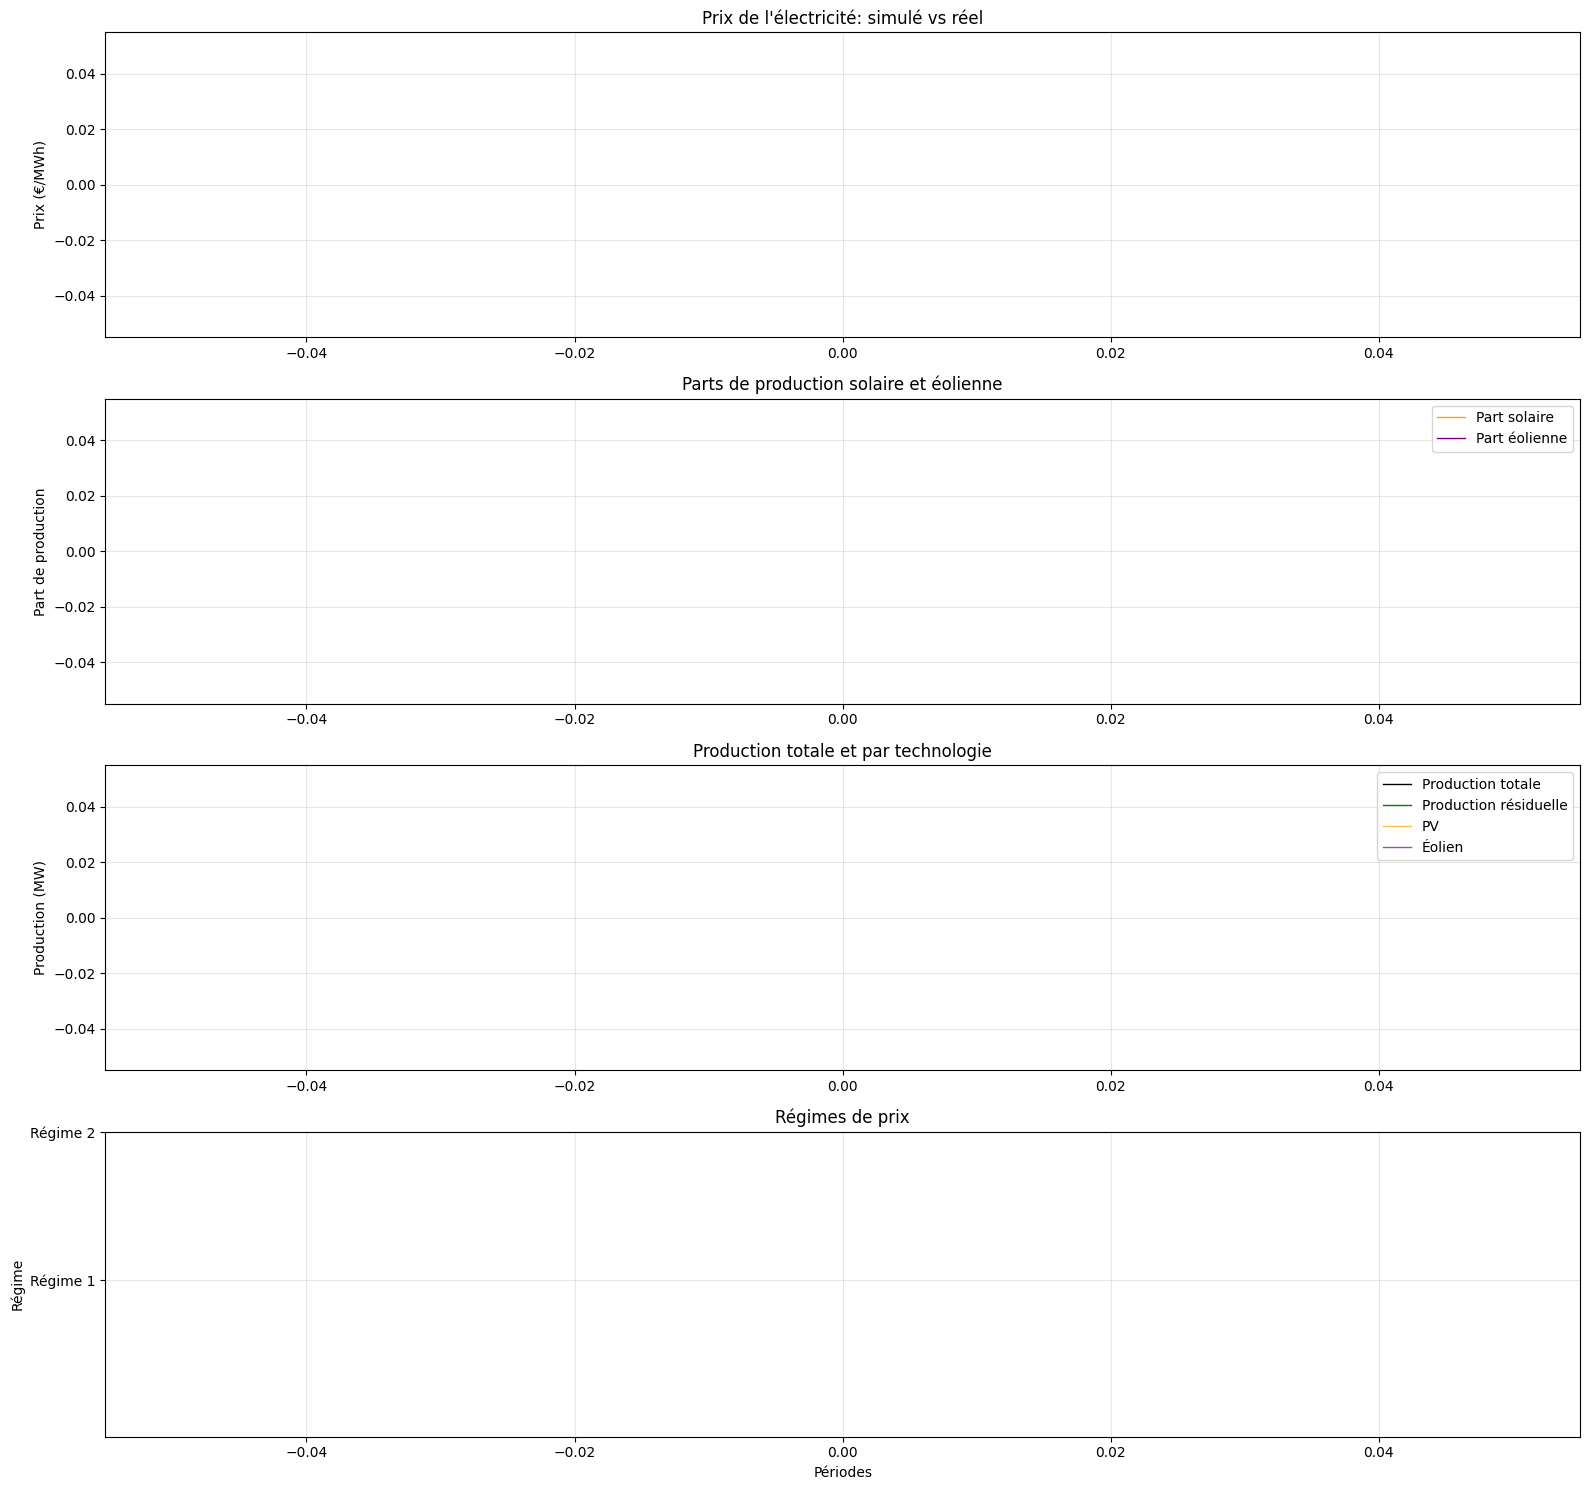

ANALYSE STATISTIQUE DU MODÈLE

1. STATISTIQUES PAR RÉGIME:
Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []

2. DISTRIBUTION DES RÉGIMES:

4. CORRÉLATIONS avec variables explicatives:
             Prix_simule  share solar  share wind  Rload
Prix_simule          NaN          NaN         NaN    NaN
share solar          NaN          NaN         NaN    NaN
share wind           NaN          NaN         NaN    NaN
Rload                NaN          NaN         NaN    NaN


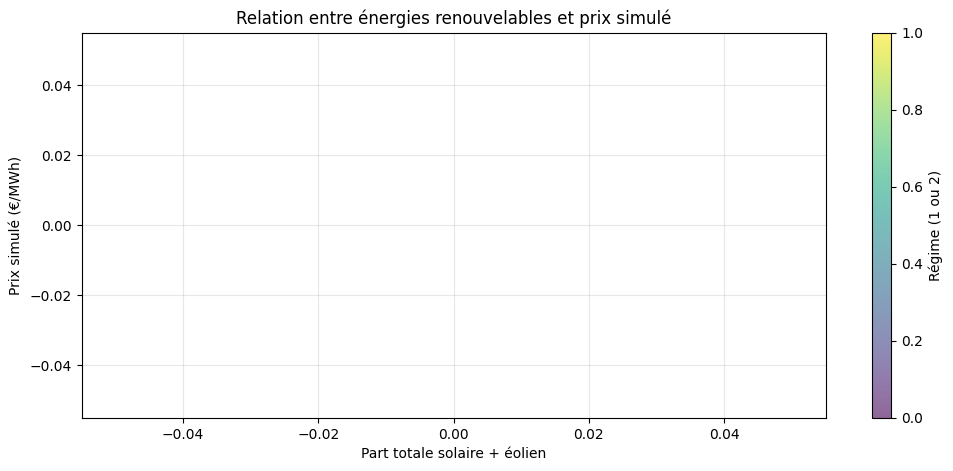

In [28]:
import elec_price_layer

DATA_DIR = cf.PROJECT_ROOT / "data"
OUTPUT_GAMS_DIR = DATA_DIR / "Modele_chronologique"
PRODVALUES_PATH = OUTPUT_GAMS_DIR / "prodValues.csv"

cf.TRANSITION_MATRIX = {'p11_solar' : 7.349472, 'p11_wind' : 14.28572, 'p21_solar' : -13.9232, 'p21_wind' : -17.944}
cf.REGIME_1 = {'c' : -6.07, 'rload' : 6.99e-05, 'share_solar' : - 1.58, 'share_wind' : - 1.07}
cf.REGIME_2 = {'c' : 2.63, 'rload' : 3.25e-05, 'share_solar' : - 0.54, 'share_wind' : - 4.12}
df_prodvalues = pd.read_csv(PRODVALUES_PATH, sep=',') # Production nationale PV et éolienne

#  Ajout de colonnes calculées
df_prodvalues['Rload'] = df_prodvalues['prod totale'] - df_prodvalues['prod PV'] - df_prodvalues['prod eolien']
df_prodvalues['share solar'] = df_prodvalues['prod PV']/df_prodvalues['prod totale']
df_prodvalues['share wind'] = df_prodvalues['prod eolien']/df_prodvalues['prod totale']


def plot_elec_price(df_results):
    """
    Fonction pour tracer les résultats de la simulation des prix de l'électricité.
    Affiche les prix simulés, les parts de production solaire et éolienne, 
    la production totale et les régimes de prix.
    """

    # Création des graphiques
    fig, axes = plt.subplots(4, 1, figsize=(16, 15))

    # 1. Prix simulé vs prix réel (si disponible)
    if 'Prix_elec' in df_results.columns:
        axes[0].plot(df_results.index, df_results['Prix_simule'], color='blue', label='Prix simulé', linewidth=1)
        axes[0].plot(df_results.index, df_results['Prix_elec'], color='red', label='Prix réel', linewidth=1, alpha=0.7)
        axes[0].legend()
    else:
        axes[0].plot(df_results.index, df_results['Prix_simule'], color='blue', linewidth=1)
    axes[0].set_ylabel('Prix (€/MWh)')
    axes[0].set_title('Prix de l\'électricité: simulé vs réel')
    axes[0].grid(True, alpha=0.3)

    # 2. Production solaire et éolienne
    axes[1].plot(df_results.index, df_results['share solar'], color='orange', label='Part solaire', linewidth=1)
    axes[1].plot(df_results.index, df_results['share wind'], color='purple', label='Part éolienne', linewidth=1)
    axes[1].set_ylabel('Part de production')
    axes[1].set_title('Parts de production solaire et éolienne')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 3. Production totale et composantes
    axes[2].plot(df_results.index, df_results['prod totale'], color='black', label='Production totale', linewidth=1)
    axes[2].plot(df_results.index, df_results['Rload'], color='green', label='Production résiduelle', linewidth=1)
    axes[2].plot(df_results.index, df_results['prod PV'], color='orange', label='PV', linewidth=1, alpha=0.7)
    axes[2].plot(df_results.index, df_results['prod eolien'], color='purple', label='Éolien', linewidth=1, alpha=0.7)
    axes[2].set_ylabel('Production (MW)')
    axes[2].set_title('Production totale et par technologie')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    # 4. Régimes de prix
    axes[3].plot(df_results.index, df_results['Régime_num'], color='red', drawstyle='steps', linewidth=1)
    axes[3].set_yticks([1, 2])
    axes[3].set_yticklabels(['Régime 1', 'Régime 2'])
    axes[3].set_ylabel('Régime')
    axes[3].set_xlabel('Périodes')
    axes[3].set_title('Régimes de prix')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_elec_price_regime(df_results):
    
    print("=" * 50)
    print("ANALYSE STATISTIQUE DU MODÈLE")
    print("=" * 50)

    # Statistiques descriptives par régime
    print("\n1. STATISTIQUES PAR RÉGIME:")
    print(df_results.groupby('Régime')['Prix_simule'].describe())

    # Pourcentage de temps dans chaque régime
    regime_counts = df_results['Régime'].value_counts()
    print(f"\n2. DISTRIBUTION DES RÉGIMES:")
    for regime, count in regime_counts.items():
        percentage = (count / len(df_results)) * 100
        print(f"  {regime}: {count} périodes ({percentage:.1f}%)")

    # Corrélations
    if 'Prix_elec' in df_results.columns:
        correlation = df_results['Prix_simule'].corr(df_results['Prix_elec'])
        print(f"\n3. CORRÉLATION avec prix réel: {correlation:.3f}")

    print(f"\n4. CORRÉLATIONS avec variables explicatives:")
    correlation_matrix = df_results[['Prix_simule', 'share solar', 'share wind', 'Rload']].corr()
    print(correlation_matrix)

    # Graphique supplémentaire : relation prix vs énergies renouvelables
    plt.figure(figsize=(12, 5))
    plt.scatter(df_results['share solar'] + df_results['share wind'], 
                df_results['Prix_simule'], 
                c=df_results['Régime_num'], cmap='viridis', alpha=0.6)
    plt.colorbar(label='Régime (1 ou 2)')
    plt.xlabel('Part totale solaire + éolien')
    plt.ylabel('Prix simulé (€/MWh)')
    plt.title('Relation entre énergies renouvelables et prix simulé')
    plt.grid(True, alpha=0.3)
    plt.show()

# ------------------------------------------------------------------
# SIMULATION DES PRIX AVEC LES DONNÉES RÉELLES
# ------------------------------------------------------------------

# Simulation des prix
regimes = []
prices = []
prices_log = []
current_regime = None  # Régime initial

# Limiter le nombre de périodes si nécessaire pour le test
n_periods = min(1000, len(df_prodvalues))  # Test sur les 1000 premières périodes ou moins

for t in range(n_periods):
    try:
        current_regime, price, price_log = elec_price_layer.elec_price(t, current_regime, df_prodvalues)
        regimes.append(current_regime)
        prices.append(price)
        prices_log.append(price_log)
    except Exception as e:
        print(f"Erreur à la période {t}: {e}")
        break

# Ajout des résultats au DataFrame
df_results = df_prodvalues.iloc[:len(prices)].copy()
df_results['Prix_simule'] = prices
df_results['Prix_log'] = prices_log
df_results['Régime'] = regimes
df_results['Régime_num'] = [1 if r == 'Régime 1' else 2 for r in regimes]


plot_elec_price(df_results)

plot_elec_price_regime(df_results)






/var/folders/f3/30sk57p17cs4rjws7xdtkfp40000gn/T/ipykernel_19613/1464559760.py:8: RuntimeWarning: invalid value encountered in log
  y = np.log(np.sinh(x))
/var/folders/f3/30sk57p17cs4rjws7xdtkfp40000gn/T/ipykernel_19613/1464559760.py:35: RuntimeWarning: invalid value encountered in log
  y_val = np.log(np.sinh(x_val))
/var/folders/f3/30sk57p17cs4rjws7xdtkfp40000gn/T/ipykernel_19613/1464559760.py:35: RuntimeWarning: divide by zero encountered in log
  y_val = np.log(np.sinh(x_val))


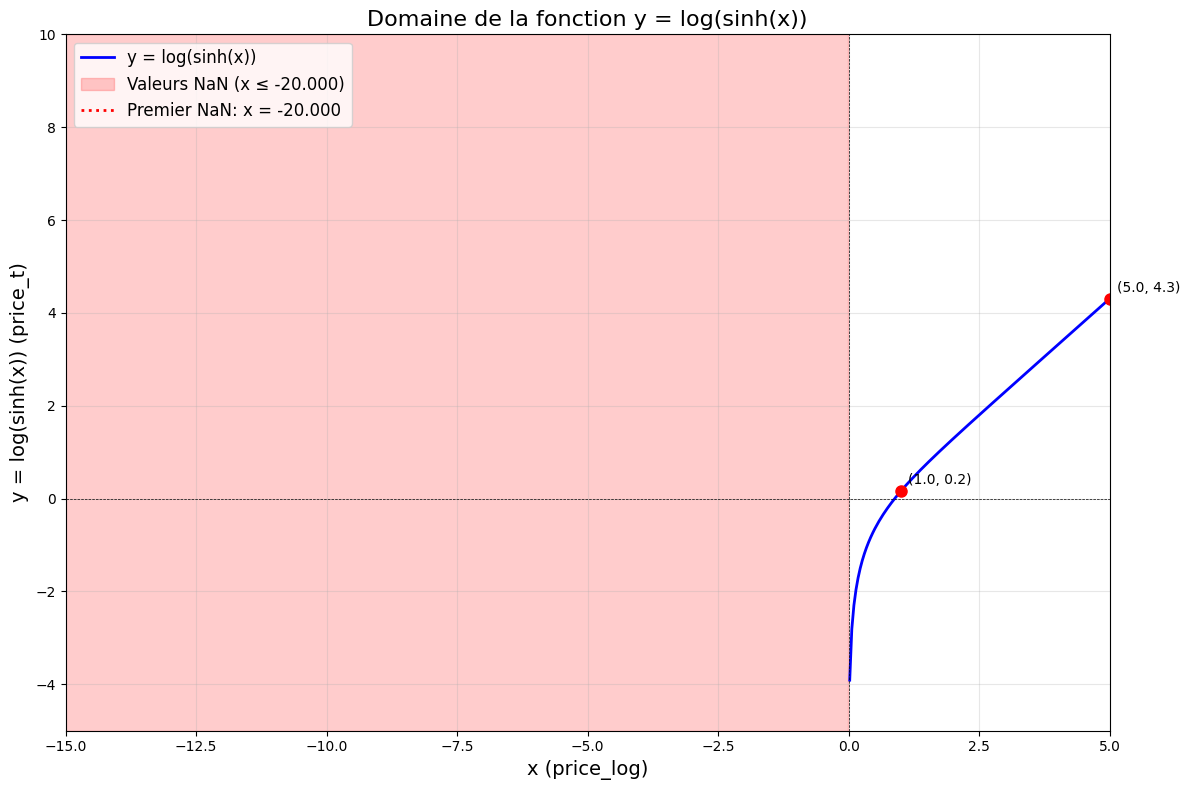

ANALYSE DE LA FONCTION log(sinh(x))
Première valeur NaN: x = -20.000000
Valeurs produisant NaN: x ≤ -20.000000

COMPORTEMENT AUX LIMITES:
x → -∞ : sinh(x) → -∞ → log(negative) → NaN
x → 0⁻ : sinh(x) → 0⁻ → log(negative) → NaN
x → 0⁺ : sinh(x) → 0⁺ → log(0⁺) → -∞
x → +∞ : sinh(x) → +∞ → log(+∞) → +∞

SEUIL EXACT:
Seuil théorique: x = 0.0
sinh(0.0) = 0.0
log(sinh(0.0)) = -inf

TEST DE VALEURS PROCHEs DE ZÉRO:
x = -1.00e-10: sinh = -1.00e-10, log(sinh) = nan
x = -1.00e-15: sinh = -1.00e-15, log(sinh) = nan
x = 0.00e+00: sinh = 0.00e+00, log(sinh) = -inf
x = 1.00e-15: sinh = 1.00e-15, log(sinh) = -3.45e+01
x = 1.00e-10: sinh = 1.00e-10, log(sinh) = -2.30e+01


/var/folders/f3/30sk57p17cs4rjws7xdtkfp40000gn/T/ipykernel_19613/1464559760.py:74: RuntimeWarning: divide by zero encountered in log
  print(f"log(sinh({threshold})) = {np.log(np.sinh(threshold))}")
/var/folders/f3/30sk57p17cs4rjws7xdtkfp40000gn/T/ipykernel_19613/1464559760.py:81: RuntimeWarning: invalid value encountered in log
  result = np.log(np.sinh(val))
/var/folders/f3/30sk57p17cs4rjws7xdtkfp40000gn/T/ipykernel_19613/1464559760.py:81: RuntimeWarning: divide by zero encountered in log
  result = np.log(np.sinh(val))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Création des valeurs x
x = np.linspace(-20, 20, 1000)  # De -20 à +20

# Calcul de y = log(sinh(x))
y = np.log(np.sinh(x))

# Identification des valeurs NaN
nan_mask = np.isnan(y)
nan_values = x[nan_mask]
first_nan = nan_values[0] if len(nan_values) > 0 else None

# Création du graphique
plt.figure(figsize=(12, 8))

# Tracé de la fonction
plt.plot(x, y, 'b-', linewidth=2, label='y = log(sinh(x))')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

# Zone des valeurs NaN
if len(nan_values) > 0:
    plt.axvspan(x.min(), nan_values[-1], alpha=0.2, color='red', 
                label=f'Valeurs NaN (x ≤ {first_nan:.3f})')

# Points importants
plt.axvline(first_nan, color='red', linestyle=':', linewidth=2, 
            label=f'Premier NaN: x = {first_nan:.3f}')

# Ajout de quelques points de référence
for x_val in [-10, -5, -1, 0, 1, 5, 10]:
    if x_val >= first_nan:
        y_val = np.log(np.sinh(x_val))
        plt.plot(x_val, y_val, 'ro', markersize=8)
        plt.annotate(f'({x_val:.1f}, {y_val:.1f})', 
                    (x_val, y_val), xytext=(5, 5), 
                    textcoords='offset points', fontsize=10)

plt.xlabel('x (price_log)', fontsize=14)
plt.ylabel('y = log(sinh(x)) (price_t)', fontsize=14)
plt.title('Domaine de la fonction y = log(sinh(x))', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.ylim(-5, 10)  # Ajustement de l'échelle y

# Zoom sur la zone critique
plt.xlim(-15, 5)

plt.tight_layout()
plt.show()

# Analyse détaillée
print("ANALYSE DE LA FONCTION log(sinh(x))")
print("=" * 40)
print(f"Première valeur NaN: x = {first_nan:.6f}")
print(f"Valeurs produisant NaN: x ≤ {first_nan:.6f}")

# Comportement aux limites
print("\nCOMPORTEMENT AUX LIMITES:")
print("x → -∞ : sinh(x) → -∞ → log(negative) → NaN")
print("x → 0⁻ : sinh(x) → 0⁻ → log(negative) → NaN") 
print("x → 0⁺ : sinh(x) → 0⁺ → log(0⁺) → -∞")
print("x → +∞ : sinh(x) → +∞ → log(+∞) → +∞")

# Calcul précis du seuil
print("\nSEUIL EXACT:")
# Le seuil est où sinh(x) = 0, donc x = 0
# Mais numériquement, le NaN apparaît légèrement avant à cause des erreurs d'arrondi
threshold = 0.0
print(f"Seuil théorique: x = {threshold}")
print(f"sinh({threshold}) = {np.sinh(threshold)}")
print(f"log(sinh({threshold})) = {np.log(np.sinh(threshold))}")

# Test de valeurs proches de zéro
print("\nTEST DE VALEURS PROCHEs DE ZÉRO:")
test_values = [-1e-10, -1e-15, 0, 1e-15, 1e-10]
for val in test_values:
    try:
        result = np.log(np.sinh(val))
        print(f"x = {val:.2e}: sinh = {np.sinh(val):.2e}, log(sinh) = {result:.2e}")
    except:
        print(f"x = {val:.2e}: NaN")

In [ ]:
float(np.log(np.sinh(0.0001)))

-18.420680743952367

In [2]:
print("Nombre d'utilisation de la batterie dans la semaine :", (df['SOC_decharge'] != 0).sum())

NameError: name 'df' is not defined

##### Comportement **hebdomadaire** de la batterie (décomposition de l'équilibre offre-demande)

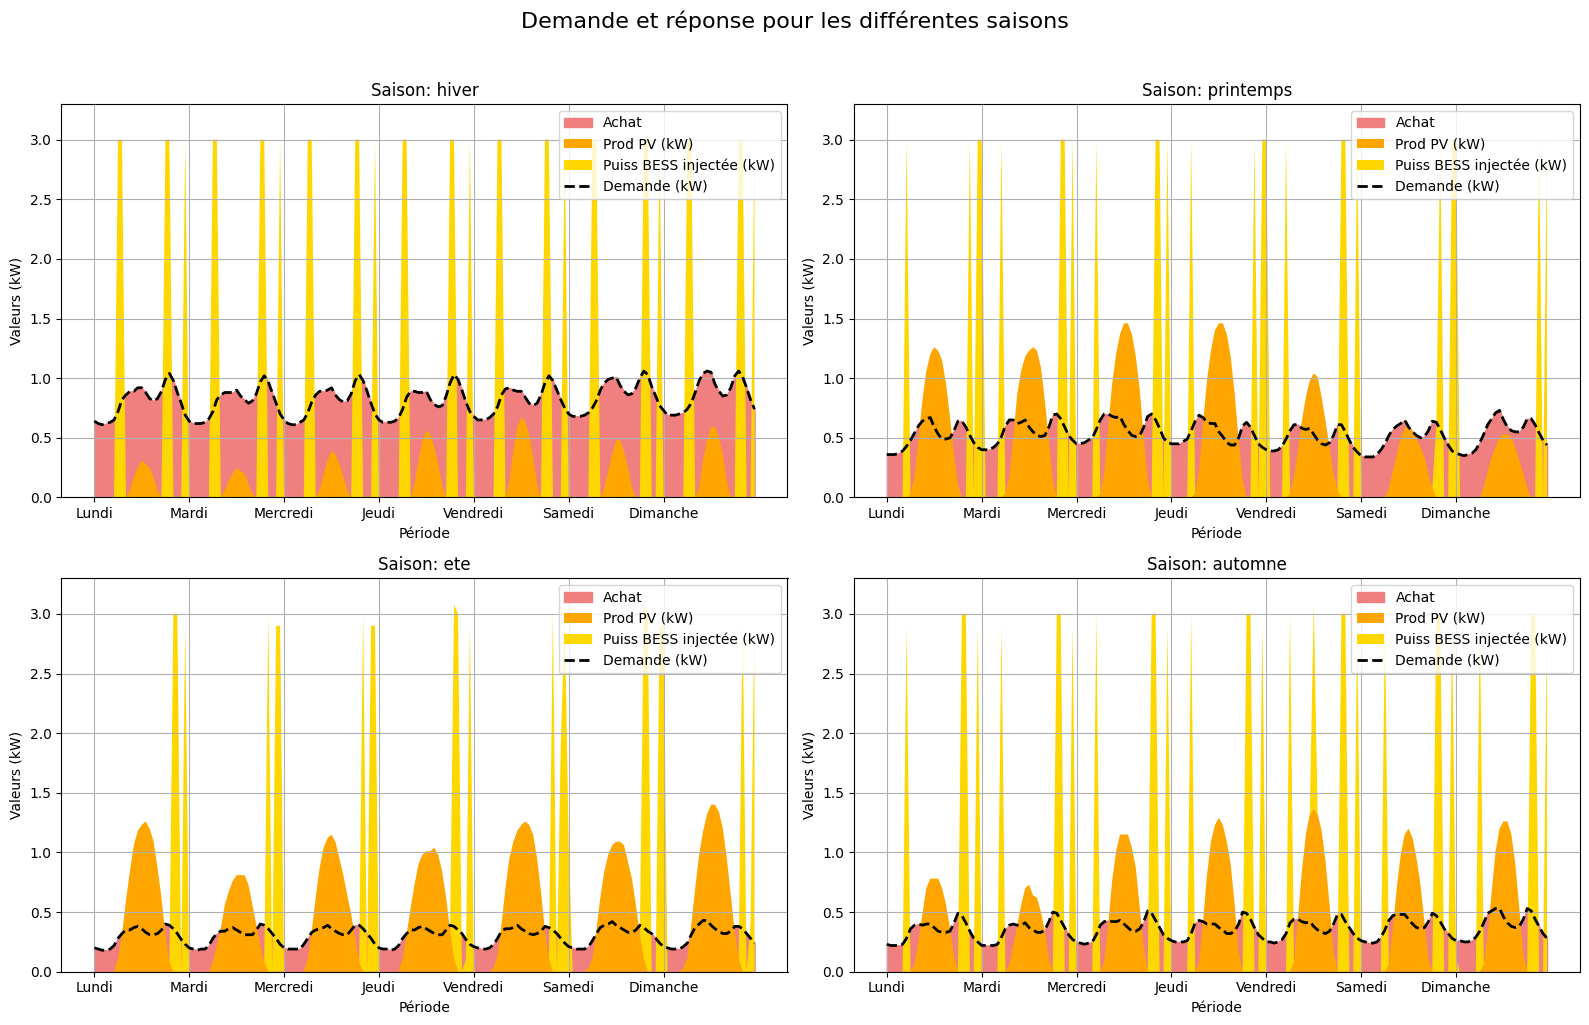

In [ ]:
def bess_injected(saison):    
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df[(df["Saison"] == saison)].copy()

    # Nettoyage des données
    filtered_df["Prod PV"] = filtered_df["Prod PV"].fillna(0).astype(float)
    filtered_df["SOC_decharge"] = filtered_df["SOC_decharge"].fillna(0).astype(float)
    

    # Créer le graphique
    plt.figure(figsize=(8, 4))

    # Utiliser la coubre "Demande" pour afficher l'électricité qu'il reste à acheter (car la colonne "Achat_t" ne fonctionn pas)
    plt.fill_between(filtered_df.index, filtered_df["Demande"], label="Achat", color="pink", alpha=1)  # Remplissage

    # Tracer les zones empilées pour "Prod PV" et "SOC_t"
    plt.stackplot(
        filtered_df.index,  # Axe X (périodes)
        filtered_df["Prod PV"],  # Première zone (Prod PV)
        filtered_df["SOC_decharge"],    # Deuxième zone (SOC_t)
        labels=["Prod PV (kW)", "Puiss BESS injectée (kW)"],  # Labels pour la légende
        colors=["orange", "gold"],     # Couleurs des zones
        alpha=1                               # Transparence
    )
    
    # Tracer la Demande comme une courbe normale
    plt.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", color="black", linestyle = '--' , linewidth=2)

    # Ajouter labels, titre, légende, grille
    plt.xlabel("Période")
    plt.ylabel("Valeurs (kW)")
    plt.title(f"Demande et réponse d'une semaine type (Saison : {saison})")
    # plt.xticks(range(start_period, end_period + 1, 3))  # Tics toutes les 3 périodes
    plt.ylim(0, max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max())*1.1)
    plt.legend(loc="upper right")  # Position de la légende en haut à droite
    
    plt.grid(True)

    # Afficher le graphique
    plt.show()

# for semaine in SEMAINES_LIST : 
#     bess_injected(semaine)

def plot_all_seasons(df, saisons_list):
    # Créer une figure avec 4 sous-graphiques (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle("Demande et réponse pour les différentes saisons", y=1.02, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    y_max = max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        ax = axes[i//2, i%2]  # Positionnement dans la grille
        filtered_df = df[df["Saison"] == saison].copy()
        
        # Nettoyage des données
        filtered_df["Prod PV"] = filtered_df["Prod PV"].fillna(0).astype(float)
        filtered_df["SOC_decharge"] = filtered_df["SOC_decharge"].fillna(0).astype(float)
        
        # Remplissage pour "Achat"
        ax.fill_between(filtered_df.index, filtered_df["Demande"], label="Achat", color="lightcoral", alpha=1)
        
        # Stackplot
        ax.stackplot(filtered_df.index,
                    filtered_df["Prod PV"],
                    filtered_df["SOC_decharge"],
                    labels=["Prod PV (kW)", "Puiss BESS injectée (kW)"],
                    colors=["orange", "gold"],
                    alpha=1)
        
        # Courbe de demande
        ax.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", color="black", linestyle='--', linewidth=2)
        
        jour_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
        ax.set_xticks(filtered_df.index[::24])
        ax.set_xticklabels(jour_semaine)
        
        # Paramètres du sous-graphique
        ax.set_title(f"Saison: {saison}")
        ax.set_xlabel("Période")
        ax.set_ylabel("Valeurs (kW)")
        ax.set_ylim(0, y_max)
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Appel de la fonction
plot_all_seasons(df, SEMAINES.keys())

##### Comportement **journalier** de la batterie (décomposition de l'équilibre offre-demande)

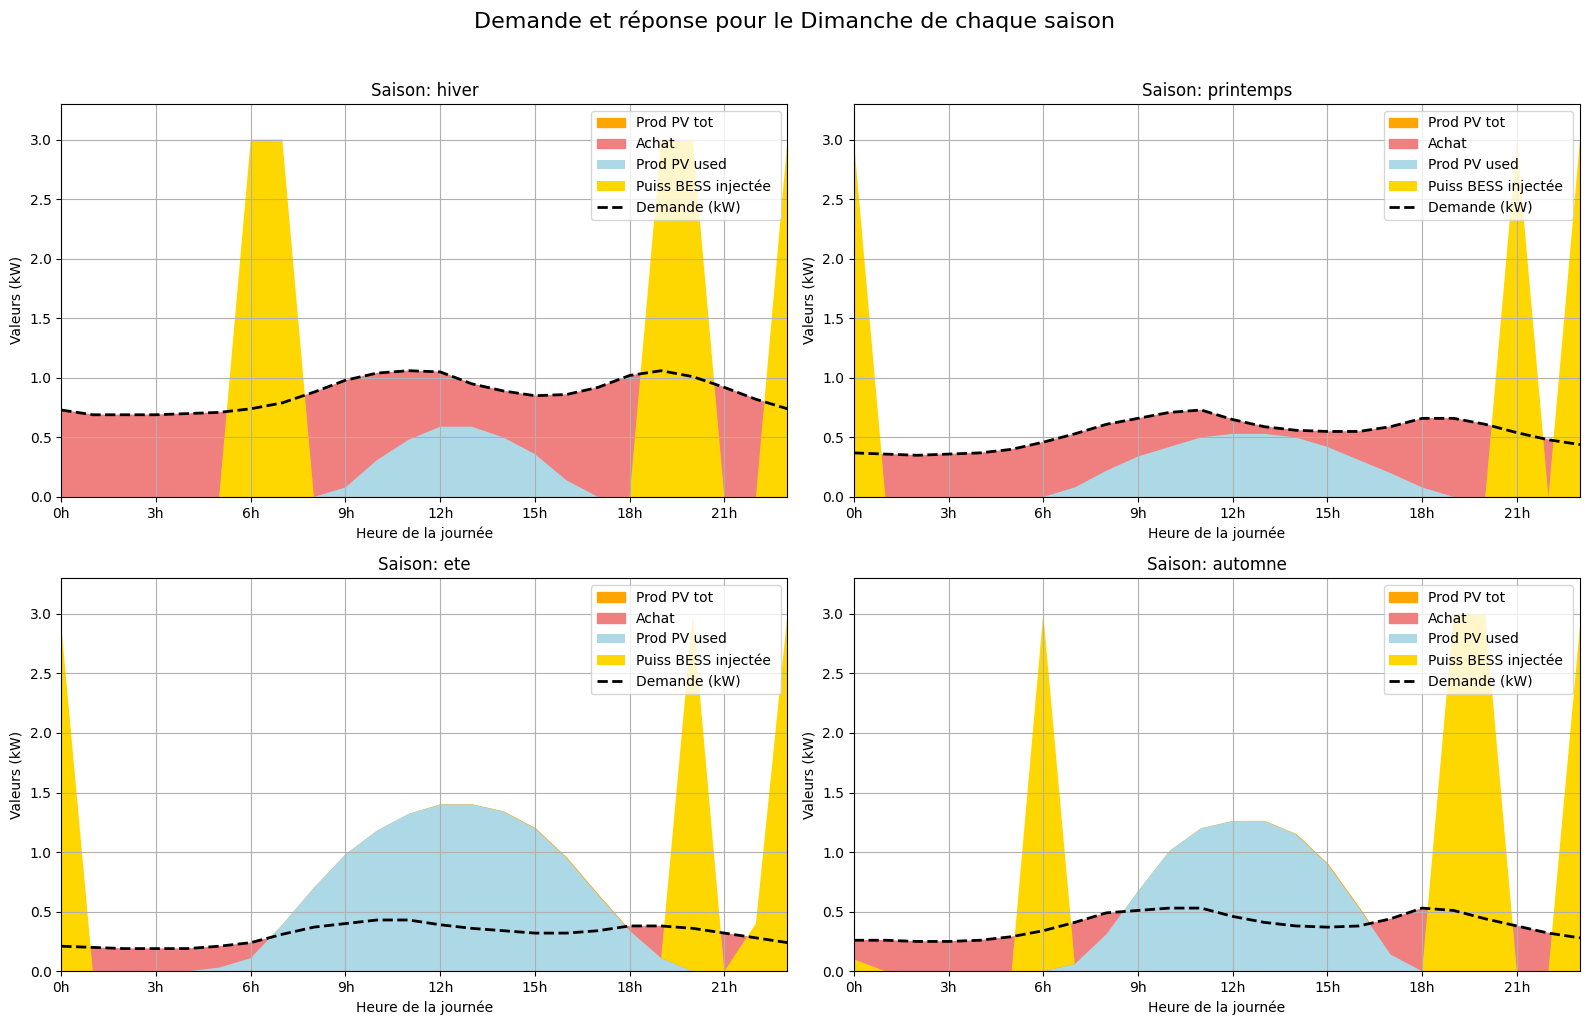

In [ ]:
def plot_all_seasons_day(df, saisons_list, jour_cible):
    # Mapping des jours de la semaine
    jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    
    # Créer une figure avec 4 sous-graphiques (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Demande et réponse pour le {jour_cible} de chaque saison", y=1.02, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    y_max = max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        ax = axes[i//2, i%2]  # Positionnement dans la grille
        
        # Filtrer la saison et extraire le jour cible
        filtered_df = df[df["Saison"] == saison].copy()
        idx_jour = jours_semaine.index(jour_cible)
        daily_data = filtered_df.iloc[idx_jour*24 : (idx_jour+1)*24].copy()  # Extraire 24h pour le jour cible
        
        # Nettoyage des données
        daily_data["Prod PV"] = daily_data["Prod PV"].fillna(0).astype(float)
        daily_data["SOC_decharge"] = daily_data["SOC_decharge"].fillna(0).astype(float)
        
        # Remplissage pour "Achat"
        ax.fill_between(range(24), daily_data["Demande"], label="Achat", color="lightcoral", alpha=1)
        
        # Stackplot
        ax.stackplot(range(24),
                    daily_data["Prod PV"],
                    daily_data["SOC_decharge"],
                    labels=["Prod PV (kW)", "Puiss BESS injectée (kW)"],
                    colors=["orange", "gold"],
                    alpha=1)
        
        # Courbe de demande
        ax.plot(range(24), daily_data["Demande"], label="Demande (kW)", color="black", linestyle='--', linewidth=2)
        
        # Configuration des ticks horaires
        ax.set_xticks(range(0, 24, 3))
        ax.set_xticklabels([f"{h}h" for h in range(0, 24, 3)])
        
        # Paramètres du sous-graphique
        ax.set_title(f"Saison: {saison}")
        ax.set_xlabel("Heure de la journée")
        ax.set_ylabel("Valeurs (kW)")
        ax.set_xlim(0, 23)
        ax.set_ylim(0, y_max)
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_all_seasons_day_well(df, saisons_list, jour_cible):
    # Mapping des jours de la semaine
    jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    
    # Créer une figure avec 4 sous-graphiques (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Demande et réponse pour le {jour_cible} de chaque saison", y=1.02, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    y_max = max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        ax = axes[i//2, i%2]  # Positionnement dans la grille
        
        # Filtrer la saison et extraire le jour cible
        filtered_df = df[df["Saison"] == saison].copy()
        idx_jour = jours_semaine.index(jour_cible)
        daily_data = filtered_df.iloc[idx_jour*24 : (idx_jour+1)*24].copy()  # Extraire 24h pour le jour cible
        
        # Nettoyage des données
        daily_data["Prod PV"] = daily_data["Prod PV"].fillna(0).astype(float)
        daily_data["SOC_decharge"] = daily_data["SOC_decharge"].fillna(0).astype(float)
        
        # Remplissage pour "Achat"
        ax.fill_between(range(24), daily_data["Prod PV"], label="Prod PV tot", color="orange", alpha=1)
        ax.fill_between(range(24), daily_data["Demande"], label="Achat", color="lightcoral", alpha=1)
        
        # Stackplot
        ax.stackplot(range(24),
                    daily_data["Prod PV"] - daily_data["Well"].round(3),
                    daily_data["SOC_decharge"],
                    labels=["Prod PV used", "Puiss BESS injectée "],
                    colors=["lightblue", "gold"],
                    alpha=1)
        
        # Courbe de demande
        ax.plot(range(24), daily_data["Demande"], label="Demande (kW)", color="black", linestyle='--', linewidth=2)
        
        # Configuration des ticks horaires
        ax.set_xticks(range(0, 24, 3))
        ax.set_xticklabels([f"{h}h" for h in range(0, 24, 3)])
        
        # Paramètres du sous-graphique
        ax.set_title(f"Saison: {saison}")
        ax.set_xlabel("Heure de la journée")
        ax.set_ylabel("Valeurs (kW)")
        ax.set_xlim(0, 23)
        ax.set_ylim(0, y_max)
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# --- Appel des fonctions --- #
# plot_all_seasons_day(df, SEMAINES.keys(), 'Mercredi')
plot_all_seasons_day_well(df, SEMAINES.keys(), 'Dimanche')

##### Évolution du SOC de la batterie

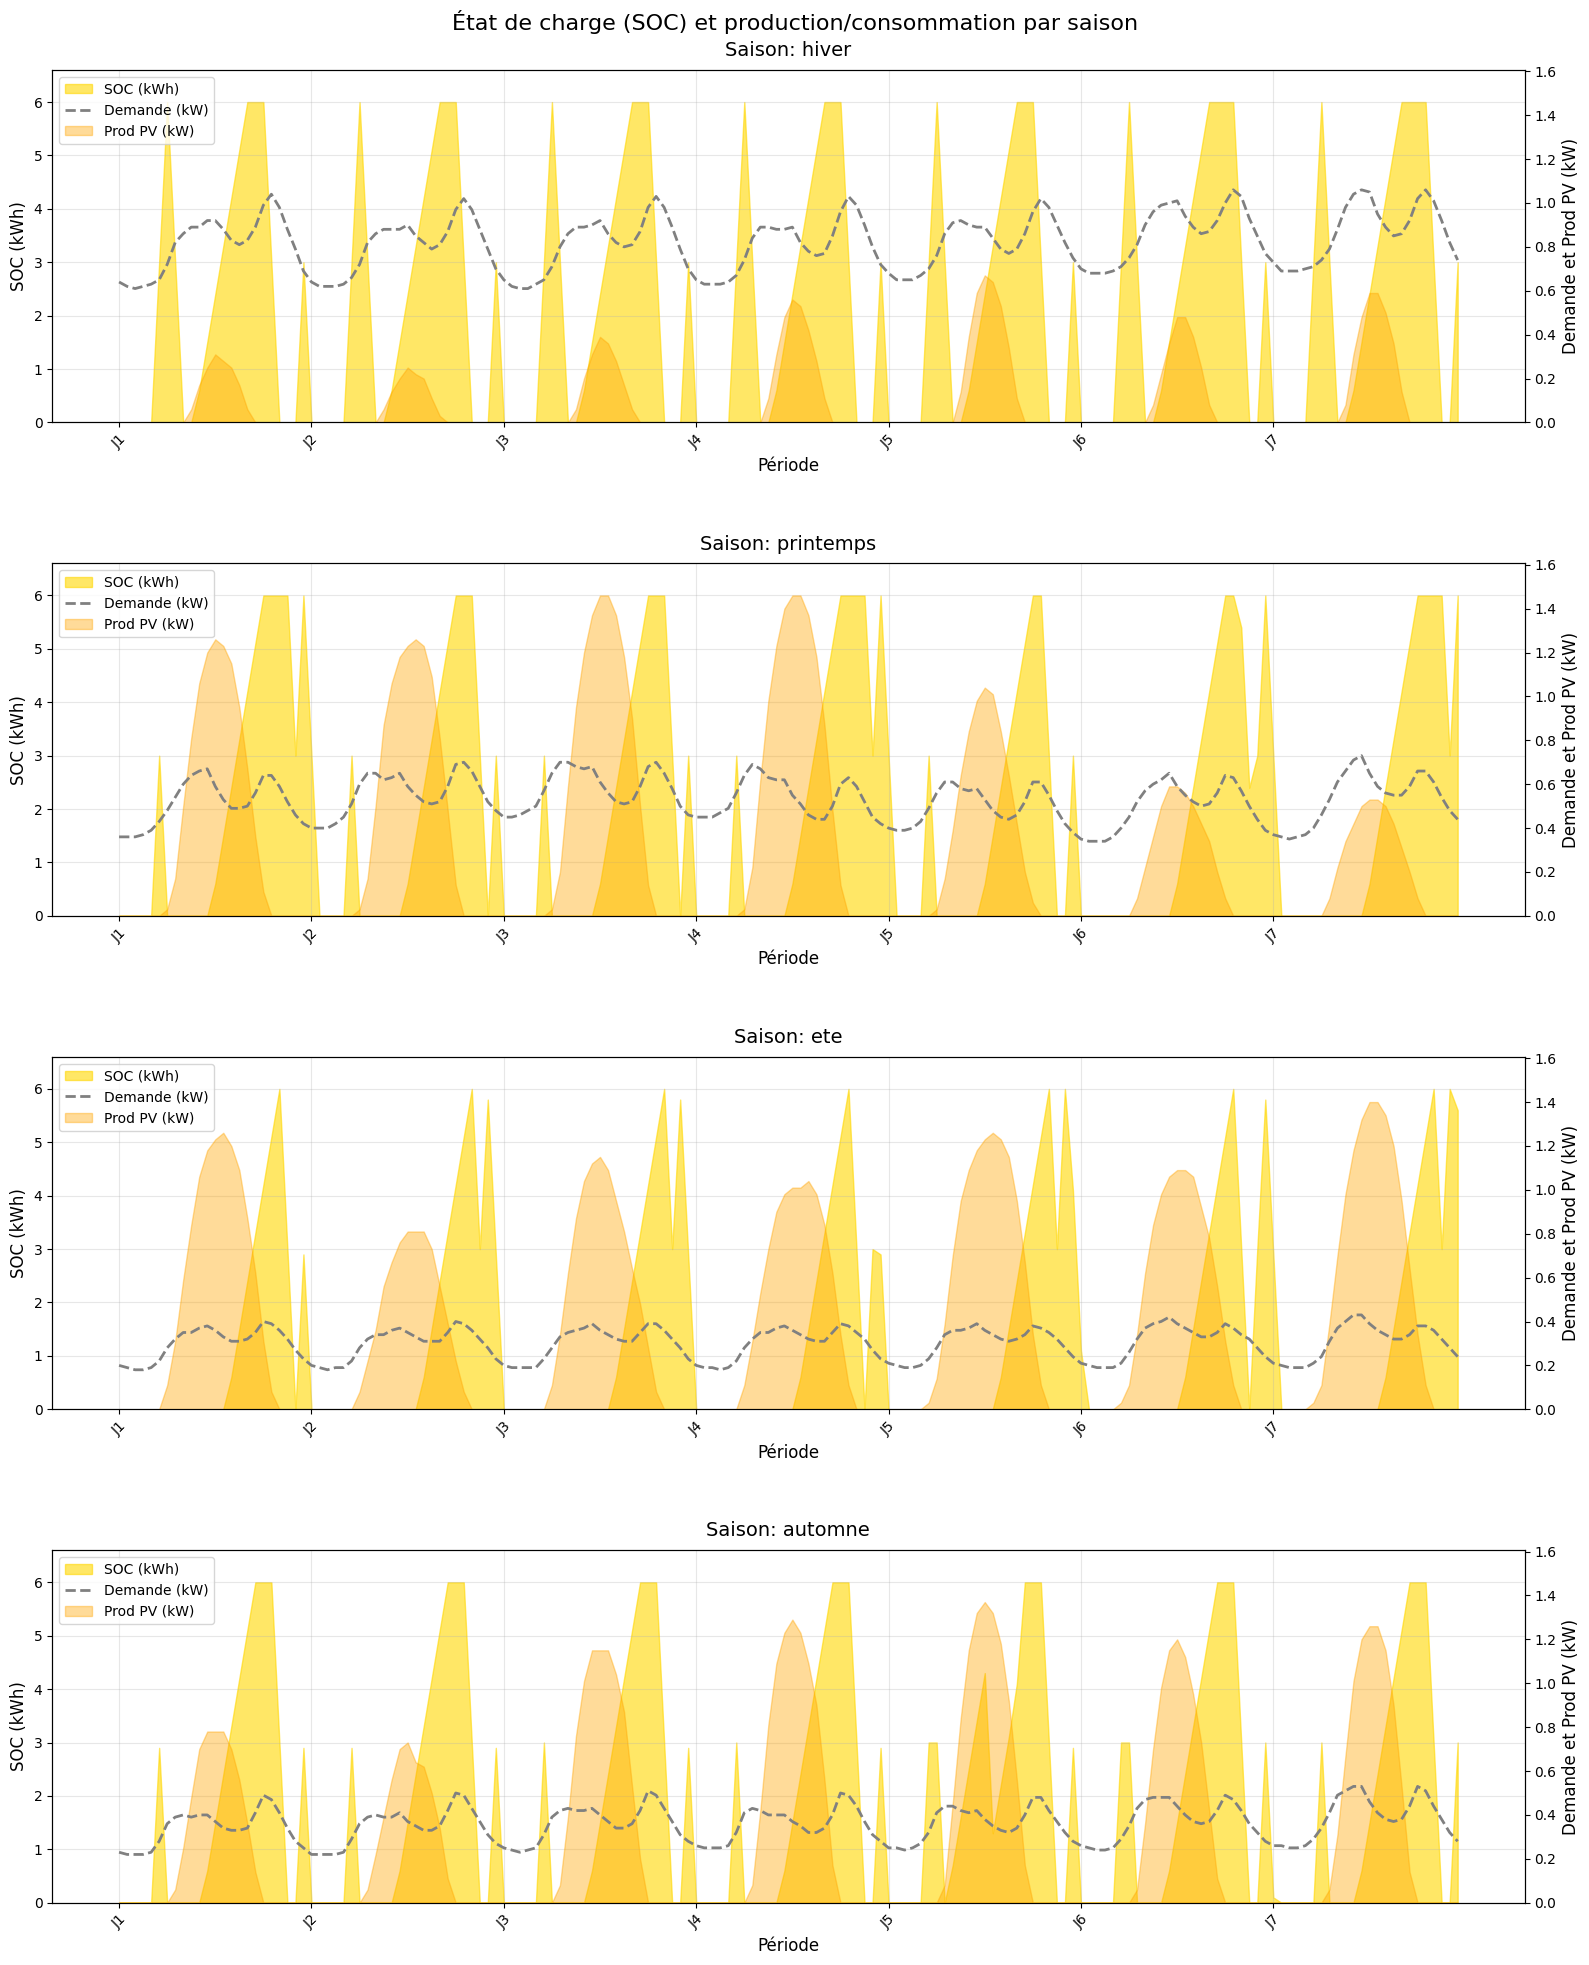

In [ ]:
def soc(saison) :
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df[(df["Saison"] == saison)].copy()
    
    # Créer une figure et un premier axe Y
    fig, ax1 = plt.subplots(figsize=(8, 4))

    ax1.fill_between(filtered_df.index, filtered_df["SOC_t"], label="SOC (kWh)", color="gold", alpha=0.6)

    ax1.set_xlabel("Périodes")
    ax1.set_ylabel("SOC (kWh)")
    ax1.tick_params(axis='y')
    ax1.grid(True)

    # Créer un deuxième axe Y partageant le même axe X
    ax2 = ax1.twinx()

    # Tracer la Demande et la Prod PV sur le premier axe Y (kWh)
    ax2.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", linestyle='--', color="grey", linewidth=2)
    ax2.fill_between(filtered_df.index, filtered_df["Prod PV"], label="Prod PV (kW)", color="orange", alpha=0.4)

    # Configurer le deuxième axe Y
    ax2.set_xlabel("Période")
    ax2.set_ylabel("Demande et Prod PV (kW)")    
    ax2.tick_params(axis='y')

    # ax1.set_xticks(range(start_period, end_period + 1, 3))  # Tics toutes les 3 périodes

    # Ajouter un titre
    plt.title(f"Demande, Prod PV et SOC_tot d'une semaine type (Saison : {saison})")
    ax1.set_ylim(0, df["SOC_t"].max()*1.1)
    ax2.set_ylim(0, max(df["Demande"].max(), df["Prod PV"].max())*1.1)

    # Combiner les légendes des deux axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.show()

def plot_all_seasons_soc_vertical(df, saisons_list):
    # Créer une figure avec 4 sous-graphiques verticaux (4x1)
    fig, axes = plt.subplots(4, 1, figsize=(16, 20))  # Largeur augmentée, hauteur adaptée
    fig.suptitle("État de charge (SOC) et production/consommation par saison", y=0.98, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    soc_max = df["SOC_t"].max() * 1.1
    demand_pv_max = max(df["Demande"].max(), df["Prod PV"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        # Sélectionner l'axe correspondant
        ax1 = axes[i]  # Chaque graphique sur sa propre ligne
        
        # Filtrer la saison
        filtered_df = df[df["Saison"] == saison].copy()
        
        # Premier axe Y (SOC)
        ax1.fill_between(filtered_df.index, filtered_df["SOC_t"], label="SOC (kWh)", color="gold", alpha=0.6)
        ax1.set_ylabel("SOC (kWh)", fontsize=12)
        ax1.tick_params(axis='y')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, soc_max)
        
        # Deuxième axe Y (Demande et Prod PV)
        ax2 = ax1.twinx()
        ax2.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", linestyle='--', color="grey", linewidth=2)
        ax2.fill_between(filtered_df.index, filtered_df["Prod PV"], label="Prod PV (kW)", color="orange", alpha=0.4)
        ax2.set_ylabel("Demande et Prod PV (kW)", fontsize=12)
        ax2.tick_params(axis='y')
        ax2.set_ylim(0, demand_pv_max)
        
        # Configuration des ticks (toutes les 24 périodes)
        ax1.set_xticks(filtered_df.index[::24])
        ax1.set_xticklabels([f'J{i//24 + 1}' for i in range(0, len(filtered_df), 24)], rotation=45)
        
        # Paramètres du sous-graphique
        ax1.set_title(f"Saison: {saison}", fontsize=14, pad=10)
        ax1.set_xlabel("Période", fontsize=12)
        
        # Combiner les légendes des deux axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=10)
    
    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.4)  # Plus d'espace vertical entre les graphiques
    plt.show()

# Appel de la fonction
plot_all_seasons_soc_vertical(df, list(SEMAINES.keys()))  # Convertir en liste pour l'ordre

# National

In [26]:
RESULTS_DIR = '/Users/vincentboltz/Documents/DOC_ENPC/Projet_IFPEN/Dossier_Modele_Complet/Modele_chronologique/results.csv'

df_nat = pd.read_csv(RESULTS_DIR, delimiter=',') 
display(df.iloc[473:493])

,Saison,Date,Heure,Demande,Prod PV,SOC_t,Vente,Achat,Well,Prix elec,SOC_decharge,Achat_t,Well_0
4577,ete,7/10/2021,17,0.35,0.56,4.2,3.0,3.69,0.00,2.948,0.00,0.00,0.0
4578,ete,7/10/2021,18,0.39,0.31,5.1,3.0,3.98,0.00,3.028,0.00,0.00,0.0
4579,ete,7/10/2021,19,0.37,0.11,6.0,2.7,0.00,0.04,3.107,2.96,0.00,0.0
4580,ete,7/10/2021,20,0.34,0.00,3.0,2.7,0.04,0.00,3.057,3.00,0.00,0.0
4581,ete,7/10/2021,21,0.32,0.00,0.0,0.0,3.32,0.00,2.988,0.00,0.32,0.0
4582,ete,7/10/2021,22,0.28,0.00,3.0,0.0,3.08,0.00,3.033,0.00,0.00,0.0
4583,ete,7/10/2021,23,0.24,0.00,5.8,2.7,0.04,0.00,3.166,2.90,0.00,0.0
4584,ete,7/11/2021,0,0.21,0.00,2.9,2.7,0.01,0.00,3.078,2.90,0.00,0.0
4585,ete,7/11/2021,1,0.20,0.00,0.0,0.0,0.20,0.00,2.895,0.00,0.20,0.0
4586,ete,7/11/2021,2,0.19,0.00,0.0,0.0,0.19,0.00,2.819,0.00,0.19,0.0


##### Demande annuelle MW

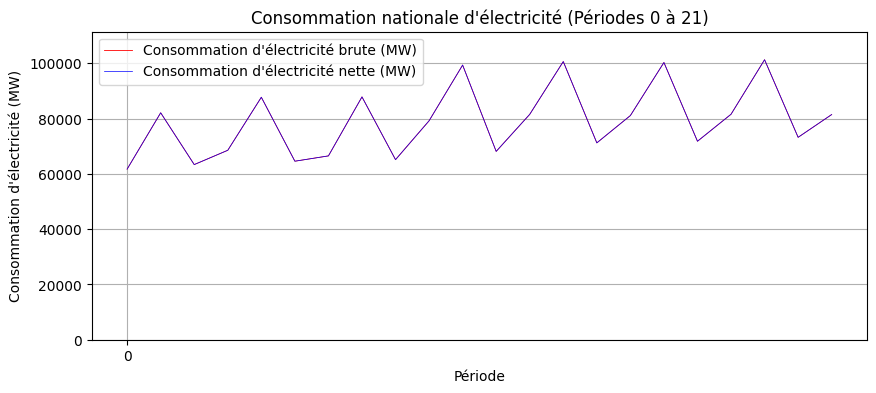

In [35]:
def graph(period) : 
    start_period, end_period = period
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df_nat[(df_nat.index >= start_period) & (df_nat.index <= end_period)].copy()

    # Créer le graphique
    plt.figure(figsize=(10, 4))
    
    plt.plot(filtered_df.index, filtered_df["demande brute"], label="Consommation d'électricité brute (MW)", color="red", linewidth=0.6)
    plt.plot(filtered_df.index, filtered_df["demande brute"], label="Consommation d'électricité nette (MW)", color="blue", linewidth=0.5)

    # Ajouter labels, titre, légende, grille
    plt.xlabel("Période")
    plt.ylabel("Consommation d'électricité (MW)")
    plt.title(f"Consommation nationale d'électricité (Périodes {start_period} à {end_period})")
    plt.xticks(range(start_period, end_period + 1, 91))  # Tics toutes les 3 périodes
    plt.ylim(0, filtered_df["demande brute"].max()*1.1)
    plt.legend()
    plt.grid(True)

    plt.show()

graph((0, 21))